
## Scikit-Learn

Scikit-Learn é uma biblioteca para aprendizado de máquina, contendo vários algoritmos assim como métodos de pré-processamento e avaliação. A biblioteca possui integração total com NumPy e Pandas para todas suas tarefas. Assim como nas outras bibliotecas iremos cobrir o material mais básico, então é recomendado conferir a documentação oficial em https://scikit-learn.org/stable/.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pré-processamento dos dados

Os dados precisam estar limpos para serem fornecidos como entrada para os algoritmos de aprendizado de máquina. Boa parte dessa limpeza já foi feita com pandas, tratando valores nulos e removendo features que não ajudariam no problema. Agora vamos continuar com a parte final do pré-processemento para que os dados possam entrar no modelo.

#### Removendo colunas desnecessárias

Vamos continuar trabalhando na base do Tomcat, então a limpeza de nulos já foi feita. Vamos ver nossa base

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Carregando os dados
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MSR-2021/Aula_02/data-hasBug/tomcat_hasBug-modified.csv', sep=';') # Salvamos com esse nome antes
df = pd.read_excel(open('/content/drive/My Drive/Mineração/tomcat_hasBug-modified.xls', 'rb'),  sheet_name='tomcat_hasBug-modified') # Salvamos com esse nome antes
df.head()

,name,version,name.1,wmc,dit,0c,cbo,rfc,lcom,ca,ce,npm,lcom3,loc,dam,moa,mfa,cam,ic,cbm,amc,max_cc,avg_cc,bug,has_bug
0,Tomcat,6.0.389418,org.apache.coyote.http11.filters.VoidOutputFilter,8,1,0,6,14,26,2,0,7,1.000000,39,1.0,2,0.00000,0.392857,0,0,3.500000e+00,1,0.75,0,0
1,Tomcat,6.0.389418,org.apache.el.parser.AstGreaterThan,2,4,0,4,5,1,1,0,2,2.000000,36,0.0,0,0.97561,0.666667,1,1,1.700000e+01,1,0.50,0,0
2,Tomcat,6.0.389418,org.apache.coyote.Request,56,1,0,49,89,1310,40,0,56,0.956474,583,1.0,24,0.00000,0.137500,0,0,8.821429e+09,5,11964.00,0,0
3,Tomcat,6.0.389418,javax.el.MethodNotFoundException,4,5,1,0,8,6,0,0,4,2.000000,20,0.0,0,1.00000,0.666667,0,0,4.000000e+00,0,0.00,0,0
4,Tomcat,6.0.389418,org.apache.naming.EjbRef,3,2,0,3,8,3,3,0,3,1.500000,73,0.0,0,0.93750,0.833333,0,0,2.200000e+01,3,1.00,0,0


Escolher qual atributos serão mantidos no modelo é um trabalho que depende de conhecimento de dominio e de experimentação. Aqui iremos remover alguns atributos baseados na nossa intuição, mas o ideal seria consultar um especialista ou testar diferentes configurações de atributos.

In [ ]:
df.drop(columns=['name', 'version'], inplace=True)
df.head()

,name.1,wmc,dit,0c,cbo,rfc,lcom,ca,ce,npm,lcom3,loc,dam,moa,mfa,cam,ic,cbm,amc,max_cc,avg_cc,bug,has_bug
0,org.apache.coyote.http11.filters.VoidOutputFilter,8,1,0,6,14,26,2,0,7,1.000000,39,1.0,2,0.00000,0.392857,0,0,3.500000e+00,1,0.75,0,0
1,org.apache.el.parser.AstGreaterThan,2,4,0,4,5,1,1,0,2,2.000000,36,0.0,0,0.97561,0.666667,1,1,1.700000e+01,1,0.50,0,0
2,org.apache.coyote.Request,56,1,0,49,89,1310,40,0,56,0.956474,583,1.0,24,0.00000,0.137500,0,0,8.821429e+09,5,11964.00,0,0
3,javax.el.MethodNotFoundException,4,5,1,0,8,6,0,0,4,2.000000,20,0.0,0,1.00000,0.666667,0,0,4.000000e+00,0,0.00,0,0
4,org.apache.naming.EjbRef,3,2,0,3,8,3,3,0,3,1.500000,73,0.0,0,0.93750,0.833333,0,0,2.200000e+01,3,1.00,0,0


#### Encoding dos dados

É necessário transformar todas as features em valores númericos para podermos usalos em um modelo. Vamos pegar como exemplo a coluna Animal. Podemos ver que seus valores são strings, então é preciso de alguma forma transformá-los em números. Existem várias maneiras de fazer isso, mas podemos destacar duas principais formas básicas: *one-hot encoding* e *label encoding*. Vamos utilizar o seguinte exemplo:

| Salário | Altura |  Animal  | Comprou |
|:-------:|:------:|:--------:|:-------:|
| 2630,00 |   170  |   Gato   |    0    |
| 5650,00 |   169  | Cachorro |    1    |
| 1250,00 |   185  |   Peixe  |    1    |
| 8900,00 |   176  | Cachorro |    0    |


<u><i>One-hot Encoding:</i></u>

Utilizando o one-hot encoding iremos criar uma coluna para cada possível valor que a variável assume. Perceba que isso pode gastar muita memória, pense numa variável como "país" que pode assumir mais de 190 valores.

| Salário | Altura | Animal Gato | Animal Cachorro | Animal Peixe | Comprou |
|:-------:|:------:|:-----------:|:---------------:|:-----------:|:-------:|
| 2630,00 |   170  |      1      |        0        |      0      |    0    |
| 5650,00 |   169  |      0      |        1        |      0      |    1    |
| 1250,00 |   185  |      0      |        0        |      1      |    1    |
| 8900,00 |   176  |      0      |        1        |      0      |    0    |


<u><i>Label Encoding:</i></u>

Já no label encoding cada possível valor da feature é mapeado para um número inteiro. Porém isso cria uma relação de ordem entre os valores que não necessariamente é desejada.

| Salário | Altura | Animal | Comprou |
|:-------:|:------:|:------:|:-------:|
| 2630,00 |   170  |    0   |    0    |
| 5650,00 |   169  |    1   |    1    |
| 1250,00 |   185  |    2   |    1    |
| 8900,00 |   176  |    1   |    0    |

Vamos aplicar a one-hot encoding nos nossos dados para eles poderem ser passados para o modelo.

In [ ]:
# Primeiro iremos conferir quais atributos não são numericos
for col in df.columns:
    if df[col].dtype == object:
        print(col)

name.1


In [ ]:
# Aplicar o one-hot encoding é bem simples
df = pd.get_dummies(df)
df.head()

,wmc,dit,0c,cbo,rfc,lcom,ca,ce,npm,lcom3,loc,dam,moa,mfa,cam,ic,cbm,amc,max_cc,avg_cc,bug,has_bug,name.1_javax.el.ArrayELResolver,name.1_javax.el.BeanELResolver,name.1_javax.el.CompositeELResolver,name.1_javax.el.ELContext,name.1_javax.el.ELContextEvent,name.1_javax.el.ELContextListener,name.1_javax.el.ELException,name.1_javax.el.ELResolver,name.1_javax.el.Expression,name.1_javax.el.ExpressionFactory,name.1_javax.el.FunctionMapper,name.1_javax.el.ListELResolver,name.1_javax.el.MapELResolver,name.1_javax.el.MethodExpression,name.1_javax.el.MethodInfo,name.1_javax.el.MethodNotFoundException,name.1_javax.el.PropertyNotFoundException,name.1_javax.el.PropertyNotWritableException,...,name.1_org.apache.tomcat.util.http.Parameters,name.1_org.apache.tomcat.util.http.ServerCookie,name.1_org.apache.tomcat.util.http.ValuesEnumerator,name.1_org.apache.tomcat.util.http.mapper.Mapper,name.1_org.apache.tomcat.util.http.mapper.MappingData,name.1_org.apache.tomcat.util.log.CaptureLog,name.1_org.apache.tomcat.util.log.SystemLogHandler,name.1_org.apache.tomcat.util.net.AprEndpoint,name.1_org.apache.tomcat.util.net.DefaultServerSocketFactory,name.1_org.apache.tomcat.util.net.LeaderFollowerWorkerThread,name.1_org.apache.tomcat.util.net.MasterSlaveWorkerThread,name.1_org.apache.tomcat.util.net.PoolTcpEndpoint,name.1_org.apache.tomcat.util.net.SSLImplementation,name.1_org.apache.tomcat.util.net.SSLSupport,name.1_org.apache.tomcat.util.net.ServerSocketFactory,name.1_org.apache.tomcat.util.net.TcpConnection,name.1_org.apache.tomcat.util.net.TcpConnectionHandler,name.1_org.apache.tomcat.util.net.URL,name.1_org.apache.tomcat.util.net.jsse.JSSE13Factory,name.1_org.apache.tomcat.util.net.jsse.JSSE13SocketFactory,name.1_org.apache.tomcat.util.net.jsse.JSSE14Factory,name.1_org.apache.tomcat.util.net.jsse.JSSE14SocketFactory,name.1_org.apache.tomcat.util.net.jsse.JSSE14Support,name.1_org.apache.tomcat.util.net.jsse.JSSE15Factory,name.1_org.apache.tomcat.util.net.jsse.JSSE15SocketFactory,name.1_org.apache.tomcat.util.net.jsse.JSSEFactory,name.1_org.apache.tomcat.util.net.jsse.JSSEImplementation,name.1_org.apache.tomcat.util.net.jsse.JSSEKeyManager,name.1_org.apache.tomcat.util.net.jsse.JSSESocketFactory,name.1_org.apache.tomcat.util.net.jsse.JSSESupport,name.1_org.apache.tomcat.util.net.puretls.PureTLSImplementation,name.1_org.apache.tomcat.util.net.puretls.PureTLSSocket,name.1_org.apache.tomcat.util.net.puretls.PureTLSSocketFactory,name.1_org.apache.tomcat.util.net.puretls.PureTLSSupport,name.1_org.apache.tomcat.util.res.StringManager,name.1_org.apache.tomcat.util.threads.Expirer,name.1_org.apache.tomcat.util.threads.Reaper,name.1_org.apache.tomcat.util.threads.ThreadPool,name.1_org.apache.tomcat.util.threads.ThreadPoolRunnable,name.1_org.apache.tomcat.util.threads.ThreadWithAttributes
0,8,1,0,6,14,26,2,0,7,1.000000,39,1.0,2,0.00000,0.392857,0,0,3.500000e+00,1,0.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,4,0,4,5,1,1,0,2,2.000000,36,0.0,0,0.97561,0.666667,1,1,1.700000e+01,1,0.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,56,1,0,49,89,1310,40,0,56,0.956474,583,1.0,24,0.00000,0.137500,0,0,8.821429e+09,5,11964.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,5,1,0,8,6,0,0,4,2.000000,20,0.0,0,1.00000,0.666667,0,0,4.000000e+00,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,2,0,3,8,3,3,0,3,1.500000,73,0.0,0,0.93750,0.833333,0,0,2.200000e+01,3,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Deixando os dados na mesma escala
Para vários algoritmos é importante deixarmos os dados em uma mesma escala, e o kNN um desses casos. Para entender melhor vamos olhar o exemplo a seguir:

<img src="imgs/grafico_escala.png" style="width: 400px"/>

Nesse caso a distância entre os dois pontos é dada por

$$
\begin{align*}
\text{dist}(x^{(1)}, x^{(2)}) &= \sqrt{(x^{(1)}_1 - x^{(2)}_1)^2 + (x^{(1)}_2 - x^{(2)}_2)^2} \\
  &= \sqrt{(3 - 2)^2 + (10000 - 9000)^2} \\
  &= \sqrt{1 + 1000000} \\
  &= \sqrt{1000001} \\
  &= 1000.0005
\end{align*}$$


Como as escalas são muito diferentes o primeiro atributo acaba não interferindo em praticamente nada no resultado da distância. E é importante perceber que esse tipo de situação ocorre com frequência em conjuntos de dados reais.

Existem diversas formas de tratar essa situação, aqui usaremos uma técnica chamada **Min-Max Scaling**, que transforma os dados deixando-os no intervalo $[0, 1]$. A formula é da transformação é a seguinte:

$$x^{(i)}_j \leftarrow \frac{x^{(i)}_j - min(x_j)}{max(x_j) - min(x_j)}$$

Em palavras significa que vamos subtrair o menor valor da atributo e dividir pela amplitude (diferença entre o máximo e o mínimo).


Pronto, agora que entendemos podemos fazer fazer isso para todas as nossas colunas utilizando a função interna do scikit-learn

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), columns=df.columns)

### Treinando um modelo de aprendizado de máquina

#### Divisão de treino e validação
Vamos dividir nossos dados entre treino e validação, estratégia que vimos na parte teórica para avaliar o desempenho do nossos modelo.

In [ ]:
# Vamos colocar em variavel quais são nossas features e qual é o target
target = 'has_bug'
features = list(df.columns)
features.remove(target)

print('Features:', features)
print('Target:', target)

Features: ['wmc', 'dit', '0c', 'cbo', 'rfc', 'lcom', 'ca', 'ce', 'npm', 'lcom3', 'loc', 'dam', 'moa', 'mfa', 'cam', 'ic', 'cbm', 'amc', 'max_cc', 'avg_cc', 'bug', 'name.1_javax.el.ArrayELResolver', 'name.1_javax.el.BeanELResolver', 'name.1_javax.el.CompositeELResolver', 'name.1_javax.el.ELContext', 'name.1_javax.el.ELContextEvent', 'name.1_javax.el.ELContextListener', 'name.1_javax.el.ELException', 'name.1_javax.el.ELResolver', 'name.1_javax.el.Expression', 'name.1_javax.el.ExpressionFactory', 'name.1_javax.el.FunctionMapper', 'name.1_javax.el.ListELResolver', 'name.1_javax.el.MapELResolver', 'name.1_javax.el.MethodExpression', 'name.1_javax.el.MethodInfo', 'name.1_javax.el.MethodNotFoundException', 'name.1_javax.el.PropertyNotFoundException', 'name.1_javax.el.PropertyNotWritableException', 'name.1_javax.el.ResourceBundleELResolver', 'name.1_javax.el.ValueExpression', 'name.1_javax.el.VariableMapper', 'name.1_javax.servlet.Filter', 'name.1_javax.servlet.FilterChain', 'name.1_javax.serv

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[features], df[target], 
                                                    test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(686, 879)
(172, 879)
(686,)
(172,)


#### Criando e treinando um modelo

In [ ]:
# Importando nosso classificador
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier #EXERC

# Criando o modelo que usa somento um vizinho
clf = KNeighborsClassifier(n_neighbors=1)
# Treinando o modelo nos dados de treino
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

Vamos ver como esse modelo se comporta nos dados de validação que separamos

In [ ]:
# Assim podemos usar o modelo para prever a classe de novos exemplos
y_pred = clf.predict(X_val)

In [ ]:
# Importar a função que calcula a acurácia
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_val, y_pred)
print('Acurácia:', acc)

Acurácia: 0.9651162790697675


#### Qual é o melhor número de vizinhos para utilizarmos?

Para esse teste usamos um modelo que olhava apenas a classe do seu vizinho mais próximo. Mas pode ser que olhando a classe mais frequente em um número maior de vinhos o resultado fique melhor. Vamos testar isso!

In [ ]:
# Criando lista com todos os números de vizinhos que queremos testar
n_vizinhos = np.arange(1, 11) # Array de 1 a 10

# Criando uma lista para guardarmos os resultados
resultados = []

# Para cada numero de vizinhos
for k in n_vizinhos:
    # Criamos um modelo novo e treinamos ele
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    
    # Fazendo predição para os dados de validação e calculando acurácia
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    
    # Salvando a acurácia para o numero atual de vizinhos
    resultados.append(acc)

Vamos fazer um gráfico com a acurácia para cada número de vizinhos

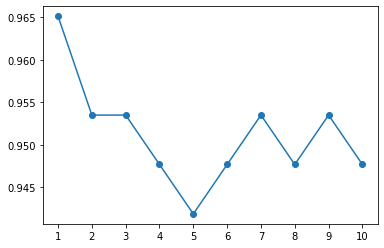

In [ ]:
# No eixo x teremos o número de vizinhos e no eixo y a acurácia
plt.plot(n_vizinhos, resultados, '-o')
# Definindo que no eixo x queremos exibir cada numero de vizinhos
plt.xticks(n_vizinhos);

Isso que acabamos de fazer é chamado otimização de hiperparâmetro (ou *hyperparameter tuning*) e é necessário para sabermos que estamos extraindo o melhor possível do nosso modelo.

**Atividade Assíncrona em dupla (23/08/21): A partir desse dataset resolver o problema de classificação utilizando o sklearn.neural_network.MLPClassifier**



#Resolução da tarefa: Utilização do MLPClassifier

Primeiramente, vamos importar o MLPClassifier da sklearn para utilizar o modelo de rede neural.

In [27]:
from sklearn.neural_network import MLPClassifier

Agora que importamos, primeiro vamos criar o classificador através de seu construtor. Pelo que pesquisamos na documentação, temos:


*   Primeiro parâmetro: A quantidade de neurônios nas camadas internas. Neste caso, definimos como 5;
*   Segundo parâmetro: A função de ativação. É uma função que será aplicada em cima dos dados processados;
*   Terceiro parâmetro: O "Solver" para realizar otimização. Neste caso, colocamos 'Adam'. Outros solvers poderiam ser utilizados para comparar o resultado também, assim como podemos fazer no Orange 3;
*   Quarto parâmetro: O número máximo de iterações da rede neural. Colocamos 400 para garantir a convergência do modelo para o melhor resultado.
*   Quinto parâmetro: Verbosidade, queremos imprimir o progresso de treinamento para acompanhar o processo.

Em seguida, realizamos o treinamento do modelo utilizando o classificador. Por fim, calculamos o Predict sobre os dados de validação, que foram separados anteriormente. A partir do y_predmlp que poderemos consultar os dados do modelo como acurácia, matriz de confusão e etc.



In [28]:
# Criação do MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(5), activation = 'relu', solver = 'adam',max_iter= 400, verbose = True)

# Realização do treinamento
mlp = mlp.fit(X_train,y_train)

# Predição no dataset de validação.
y_predmlp = mlp.predict(X_val)

Iteration 1, loss = 0.59079502
Iteration 2, loss = 0.58503155
Iteration 3, loss = 0.57932316
Iteration 4, loss = 0.57400292
Iteration 5, loss = 0.56873578
Iteration 6, loss = 0.56328960
Iteration 7, loss = 0.55788830
Iteration 8, loss = 0.55240155
Iteration 9, loss = 0.54676307
Iteration 10, loss = 0.54085203
Iteration 11, loss = 0.53461261
Iteration 12, loss = 0.52810232
Iteration 13, loss = 0.52112815
Iteration 14, loss = 0.51386651
Iteration 15, loss = 0.50657002
Iteration 16, loss = 0.49871514
Iteration 17, loss = 0.49082971
Iteration 18, loss = 0.48283982
Iteration 19, loss = 0.47483430
Iteration 20, loss = 0.46673792
Iteration 21, loss = 0.45891559
Iteration 22, loss = 0.45127313
Iteration 23, loss = 0.44394383
Iteration 24, loss = 0.43684909
Iteration 25, loss = 0.42992155
Iteration 26, loss = 0.42320012
Iteration 27, loss = 0.41688926
Iteration 28, loss = 0.41061622
Iteration 29, loss = 0.40454400
Iteration 30, loss = 0.39873385
Iteration 31, loss = 0.39312091
Iteration 32, los

Agora que temos o modelo treinado e realizamos o processamento de validação, podemos imprimir a matriz de confusão:

In [29]:
# Impoprtando as metricas
from sklearn import metrics


# Impressão da matriz de confusão
cnf_matrixmlp = metrics.confusion_matrix(y_val, y_predmlp)
cnf_matrixmlp

array([[159,   2],
       [  6,   5]])

Nessa execução, tivemos o resultado de:

[[160,   1],

[  6,   5]]

Neste caso, podemos ver que o modelo é interessante. Tivemos 160 casos de acertos quando a entrada possuía bug e 5 casos de acerto quando a entrada não possuia bug. Logo, tivemos apenas 7 casos em que o modelo falhou.


Podemos também verificar a acurácia do modelo. Nesta execução, tivemos uma acurácia de 95%, sendo um valor próximo do outro modelo utilizado anteriormente (96%), provando que este modelo de rede neural também é interessante.

In [30]:
# Medição da acurácia
acc_mlp = metrics.accuracy_score(y_val, y_predmlp)

# Impressão da acurácia
print("Accuracy:", acc_mlp)

Accuracy: 0.9534883720930233
